In [ ]:
!pip install langchain_anthropic

In [3]:
from typing import Annotated, Sequence, TypedDict
from langgraph.graph import StateGraph, END
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage

In [4]:
from getpass import getpass
import os

claude_api_key = getpass("Enter Claude api key: ")
os.environ['ANTRHOPIC_API_KEY'] = claude_api_key

Enter Claude api key: ··········


In [9]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [10]:
@tool
def add(a: int, b: int):
  """ Adds two numbers a and b """
  return a + b

@tool
def subtract(a: int, b: int):
  """ Subtracts two numbers a and b """
  return a - b

@tool
def multiply(a: int, b: int):
  """ Multiplies two numbers a and b """
  return a * b

tools = [add, subtract, multiply]

In [26]:
model = ChatAnthropic(
    model = "claude-sonnet-4-20250514",
    anthropic_api_key = claude_api_key
).bind_tools(tools)

In [27]:
def model_call(state: AgentState) -> AgentState:
  """ Answers the user's query """
  system_prompt = SystemMessage(
      content = "You are a helpful AI Assistant. Please answer the user's query with the best of your abilities."
  )

  response = model.invoke([system_prompt] + state['messages'])
  return {"messages": [response]}

In [28]:
def should_continue(state: AgentState):
  """ Decider whether to continue calling tools or end the graph workflow """

  messages = state['messages']
  last_message = messages[-1]

  if not last_message.tool_calls:
    return "end"
  else:
    return "continue"

In [29]:
graph = StateGraph(AgentState)

graph.add_node("our_agent", model_call)
graph.set_entry_point("our_agent")
tool_node = ToolNode(tools = tools)
graph.add_node("tools", tool_node)
graph.add_conditional_edges(
    "our_agent",
    should_continue,

    {
        # Edge: Node
        "continue": "tools",
        "end": END
    }
)
graph.add_edge("tools", "our_agent")
agent = graph.compile()

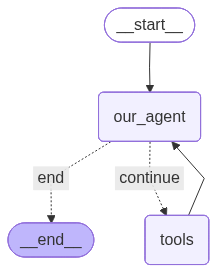

In [30]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [31]:
def print_stream(stream):
  for s in stream:
    message = s["messages"][-1]
    if isinstance(message, tuple):
      print(message)

    else:
      message.pretty_print()

In [32]:
inputs = {"messages": [("user", "Add 34+21. Add 3+4. Add 12 + 12")]}
print_stream(agent.stream(inputs, stream_mode = "values"))

================================ Human Message =================================

Add 34+21. Add 3+4. Add 12 + 12
================================== Ai Message ==================================

[{'text': "I'll help you perform these three addition operations.", 'type': 'text'}, {'id': 'toolu_01WmH9rC9Ax6u8QjCrG3eHwz', 'input': {'a': 34, 'b': 21}, 'name': 'add', 'type': 'tool_use'}, {'id': 'toolu_019Hm3DPdph6Zny6JESD4csH', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}, {'id': 'toolu_0189yV3YgHtZZHSzxAYWicNG', 'input': {'a': 12, 'b': 12}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01WmH9rC9Ax6u8QjCrG3eHwz)
 Call ID: toolu_01WmH9rC9Ax6u8QjCrG3eHwz
  Args:
    a: 34
    b: 21
  add (toolu_019Hm3DPdph6Zny6JESD4csH)
 Call ID: toolu_019Hm3DPdph6Zny6JESD4csH
  Args:
    a: 3
    b: 4
  add (toolu_0189yV3YgHtZZHSzxAYWicNG)
 Call ID: toolu_0189yV3YgHtZZHSzxAYWicNG
  Args:
    a: 12
    b: 12
================================= Tool Message ======================

In [34]:
inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please")]}
print_stream(agent.stream(inputs, stream_mode = "values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please
================================== Ai Message ==================================

[{'text': "I'll help you with that calculation and tell you a joke!", 'type': 'text'}, {'id': 'toolu_01JyTJzr5djMuXNZqkoXWq3h', 'input': {'a': 40, 'b': 12}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_01JyTJzr5djMuXNZqkoXWq3h)
 Call ID: toolu_01JyTJzr5djMuXNZqkoXWq3h
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================

[{'id': 'toolu_01MQXnRyfX9dxRuLJZSXrJKh', 'input': {'a': 52, 'b': 6}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01MQXnRyfX9dxRuLJZSXrJKh)
 Call ID: toolu_01MQXnRyfX9dxRuLJZSXrJKh
  Args:
    a: 52
    b: 6
================================= Too